TODO:
- GD-1
- Ophiuchus
- Pal 5
- Jhelum
- OC

In [304]:
import re

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams as gs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.io import fits
from gala.units import galactic
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline

%matplotlib inline

In [7]:
stream_c = {}

In [305]:
mws = gs.MWStreams()

Initializing galstreams library from master_log... 


# GD-1

In [316]:
track_c = mws["GD-1-I21"].track.transform_to(gc.GD1Koposov10())
phi2_spl = InterpolatedUnivariateSpline(track_c.phi1.degree, track_c.phi2.degree, k=3)

In [323]:
data = at.QTable.read("../data/gd-1/gd1_memb_prob_post_CMD_cut.fits")

track_mask = np.abs(data["phi2"].value - phi2_spl(data["phi1"].value)) < 2
mask = (data["memb_prob"] > 0.995) & track_mask
data = data[mask]

In [324]:
stream_c["gd-1"] = coord.SkyCoord(
    phi1=data["phi1"], phi2=data["phi2"], frame=gc.GD1Koposov10()
)

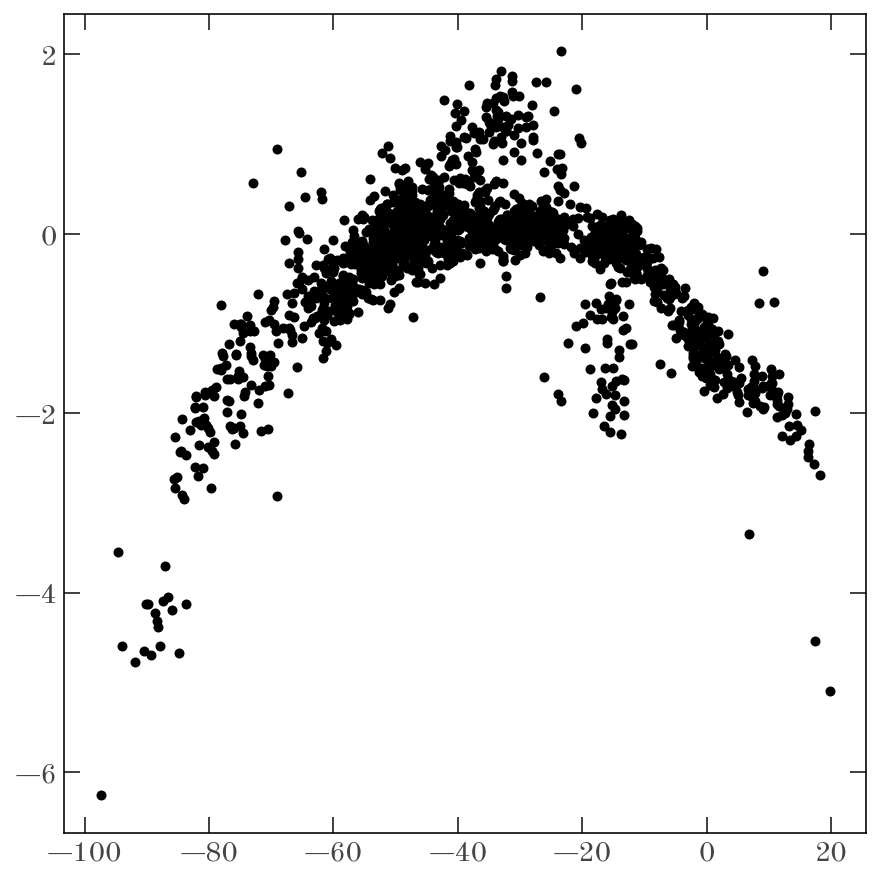

In [325]:
plt.plot(
    stream_c["gd-1"].phi1.degree, stream_c["gd-1"].phi2.degree, marker="o", ls="none"
)

# Pal 5

In [347]:
data = at.Table.read(
    "/Users/apricewhelan/projects/pal5s-biggest-fan/data/pal5_ls_lite_grz.fits"
)
masks = at.Table.read(
    "/Users/apricewhelan/projects/pal5s-biggest-fan/data/cmd_masks_orig.fits"
)

c = coord.SkyCoord(data["ra"], data["dec"], unit=u.deg)
stream_c["pal5"] = c.transform_to(gc.Pal5PriceWhelan18())[
    masks["gr_mask"] & masks["grz_mask"]
]

In [431]:
data = at.Table.read("/Users/apricewhelan/projects/pal5-rrl/data/RRL-with-prob.fits")
pal5_rrl = data[(data["member_prob"] > 0.5) & (data["inside_stream_track"])]
pal5_rrl_c = coord.SkyCoord(
    pal5_rrl["ra"] * u.deg, pal5_rrl["dec"] * u.deg
).transform_to(gc.Pal5PriceWhelan18())
print(len(pal5_rrl))

24


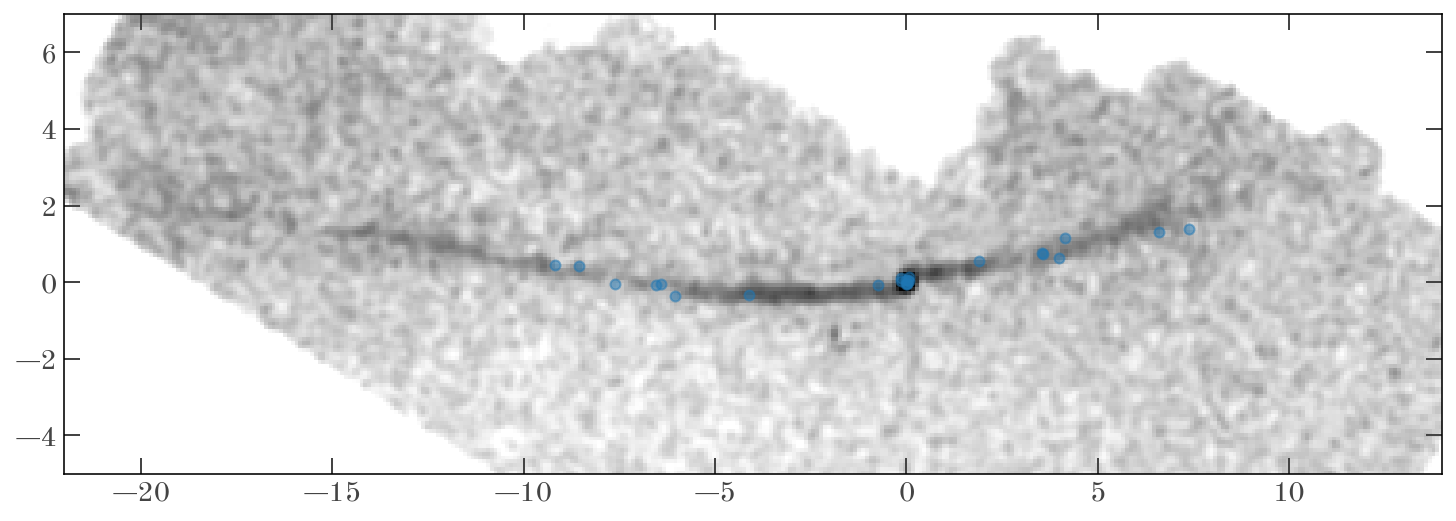

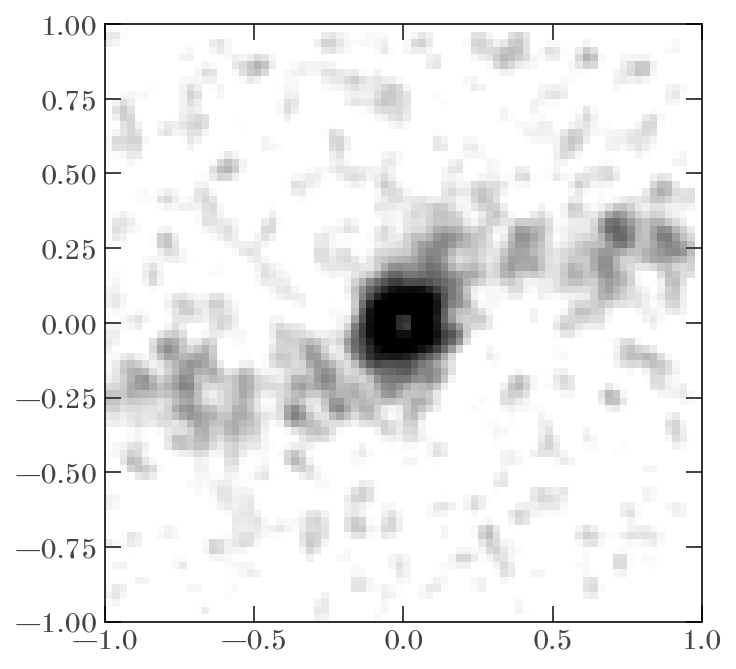

In [433]:
dx = 0.1
H, xe, ye = np.histogram2d(
    stream_c["pal5"].phi1.degree,
    stream_c["pal5"].phi2.degree,
    bins=(
        np.arange(
            stream_c["pal5"].phi1.degree.min(), stream_c["pal5"].phi1.degree.max(), dx
        ),
        np.arange(
            stream_c["pal5"].phi2.degree.min(), stream_c["pal5"].phi2.degree.max(), dx
        ),
    ),
)
H = convolve(H, Gaussian2DKernel(1))
pal5_im = {"xe": xe, "ye": ye, "H": H}

pal5_inset = np.histogram2d(
    stream_c["pal5"].phi1.degree,
    stream_c["pal5"].phi2.degree,
    bins=np.arange(-1, 1, 0.025),
)
pal5_inset = {
    "H": convolve(pal5_inset[0], Gaussian2DKernel(1)),
    "xe": pal5_inset[1],
    "ye": pal5_inset[2],
}

fig, ax = plt.subplots(figsize=(10, 6))
ax.pcolormesh(xe, ye, H.T, cmap="Greys", norm=mpl.colors.LogNorm(vmin=1.0, vmax=2e1))
ax.scatter(pal5_rrl_c.phi1.degree, pal5_rrl_c.phi2.degree, color="tab:blue", alpha=0.5)
ax.set(xlim=(-22, 14), ylim=(-5, 7), aspect="equal")

fig, ax = plt.subplots(figsize=(5, 5))
ax.pcolormesh(
    pal5_inset["xe"],
    pal5_inset["ye"],
    pal5_inset["H"].T,
    cmap="Greys",
    norm=mpl.colors.LogNorm(vmin=0.2, vmax=5),
)
ax.set(xlim=(-1, 1), ylim=(-1, 1), aspect="equal");

# Jhelum

In [382]:
data = at.Table.read("../data/jhelum/Awad2024-JhelumComponentProb.csv")
stream_c["jhelum"] = [
    coord.SkyCoord(ra=data["ra"] * u.deg, dec=data["dec"] * u.deg).transform_to(
        gc.JhelumBonaca19()
    )[mask]
    for mask in [data["probability"] > 0.5, data["probability"] <= 0.5]
]

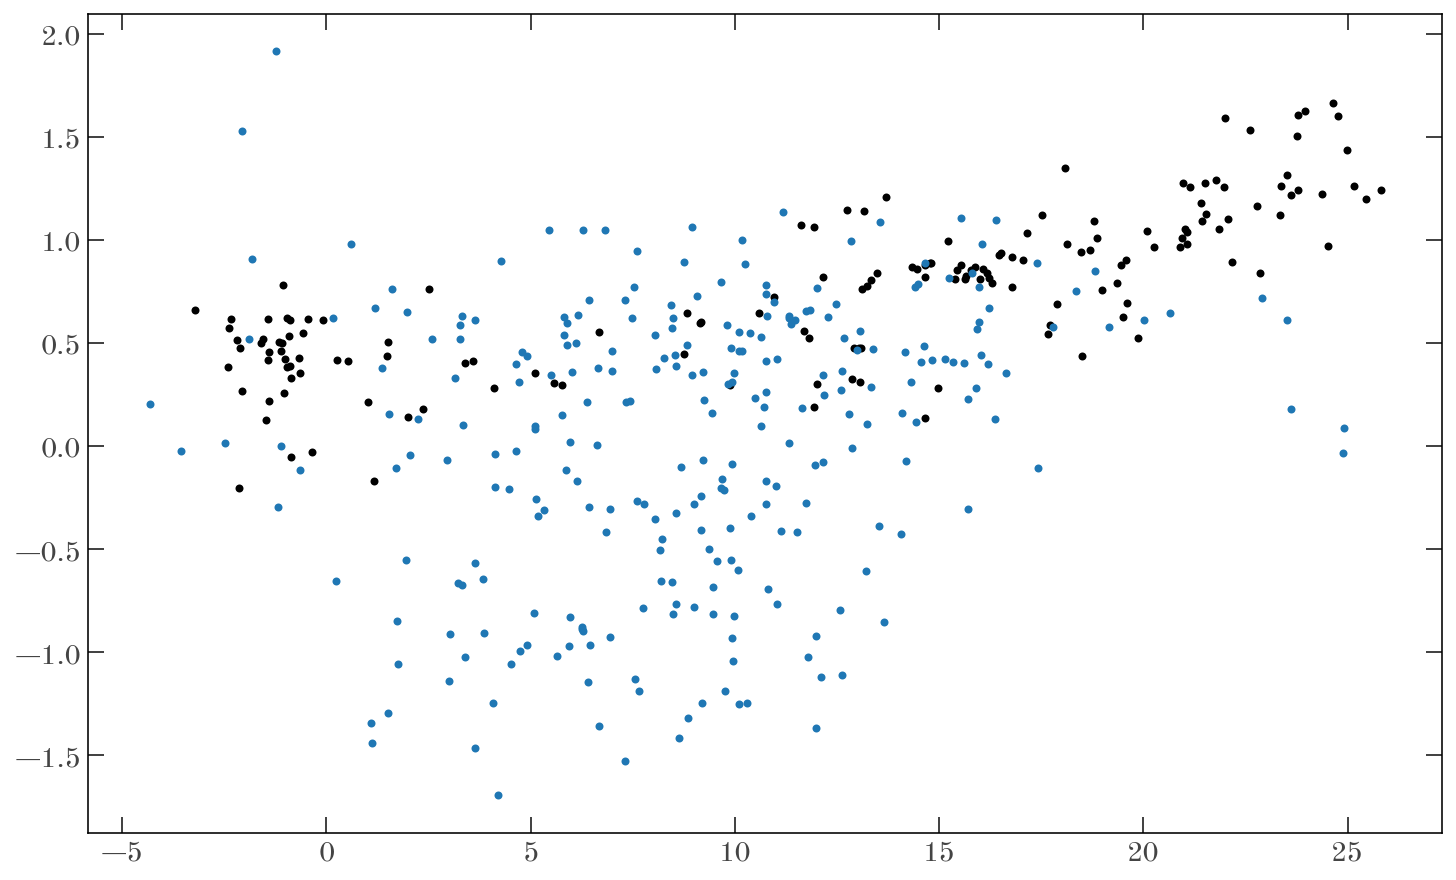

In [384]:
fig, ax = plt.subplots(figsize=(10, 6))

for c in stream_c["jhelum"]:
    ax.plot(
        c.phi1.degree,
        c.phi2.degree,
        ls="none",
        marker="o",
        mew=0,
        ms=4.0,
        alpha=1.0,
    )

# OC

In [388]:
orp_im = fits.getdata(
    "../data/orphan/koposov2023-measurement_tables/images/orphan_datMbg.fits", 1
)

phi2_tbl = at.Table.read(
    "../data/orphan/koposov2023-measurement_tables/fitses/orphan_M_track_bins.fits"
)
pm1_tbl = at.Table.read(
    "../data/orphan/koposov2023-measurement_tables/fitses/orphan_M_pm1_bins.fits"
)
pm2_tbl = at.Table.read(
    "../data/orphan/koposov2023-measurement_tables/fitses/orphan_M_pm2_bins.fits"
)
# pm1_tbl = at.Table.read('../data/orphan/koposov2023-measurement_tables/fitses/orphan_pm1_bins.fits')
# pm2_tbl = at.Table.read('../data/orphan/koposov2023-measurement_tables/fitses/orphan_pm2_bins.fits')
dm_tbl = at.Table.read(
    "../data/orphan/koposov2023-measurement_tables/fitses/orphan_dmrr_bins.fits"
)

phi2_spl = InterpolatedUnivariateSpline(phi2_tbl["phi1"], phi2_tbl["phi2"], k=3)
pm1_spl = InterpolatedUnivariateSpline(pm1_tbl["phi1"], pm1_tbl["pmphi1"], k=3)
pm2_spl = InterpolatedUnivariateSpline(pm2_tbl["phi1"], pm2_tbl["pmphi2"], k=3)
dm_spl = InterpolatedUnivariateSpline(dm_tbl["phi1"], dm_tbl["dm"], k=3)

In [389]:
phi1_grid = np.linspace(-80, 120, 25)

track_c = coord.SkyCoord(
    phi1=phi1_grid * u.deg,
    phi2=phi2_spl(phi1_grid) * u.deg,
    distance=coord.Distance(distmod=dm_spl(phi1_grid)),
    pm_phi1_cosphi2=pm1_spl(phi1_grid) * u.mas / u.yr,
    pm_phi2=pm2_spl(phi1_grid) * u.mas / u.yr,
    radial_velocity=np.zeros_like(phi1_grid) * u.km / u.s,
    frame=gc.OrphanKoposov19(),
)
orp_track_c_refl = gc.reflex_correct(track_c, coord.Galactocentric())

In [390]:
orp_pm = np.stack(
    (orp_track_c_refl.pm_phi1_cosphi2.value, orp_track_c_refl.pm_phi2.value)
).T
orp_pm /= np.linalg.norm(orp_pm, axis=1)[:, None]
orp_pm *= 0.5

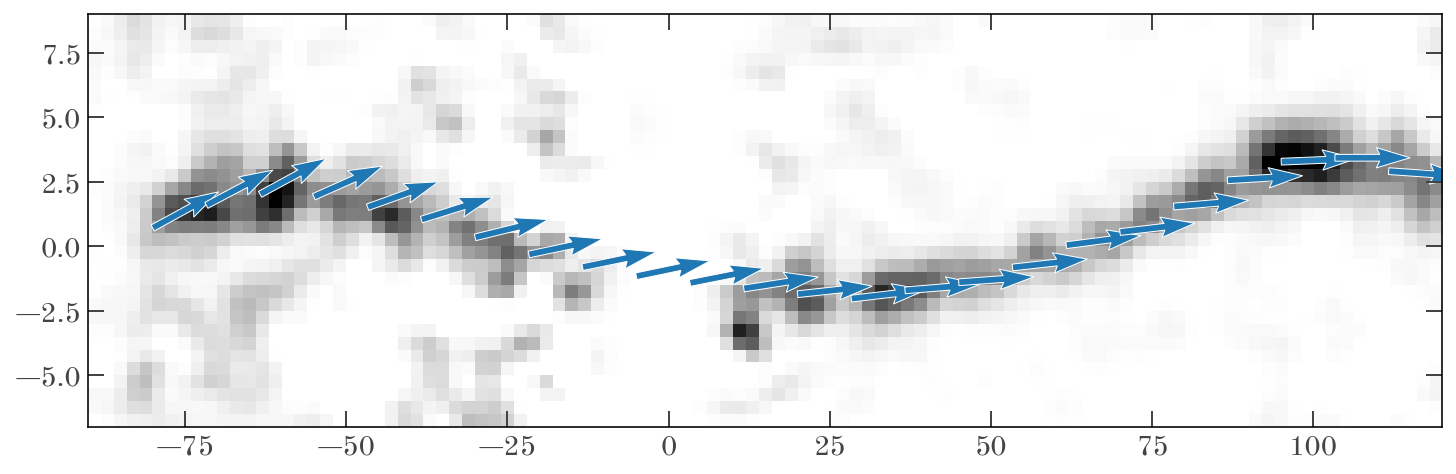

In [205]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.imshow(
    convolve(orp_im.T, Gaussian2DKernel(1.0)),
    extent=(-90, 120, -7, 9),
    cmap="Greys",
    vmin=0,
    vmax=4,
    origin="lower",
)

ax.quiver(
    orp_track_c_refl.phi1.degree,
    orp_track_c_refl.phi2.degree,
    pm[:, 0],
    pm[:, 1],
    width=5e-3,
    color="tab:blue",
    linewidth=0.5,
    edgecolor="w",
)
ax.set_aspect(4)

---

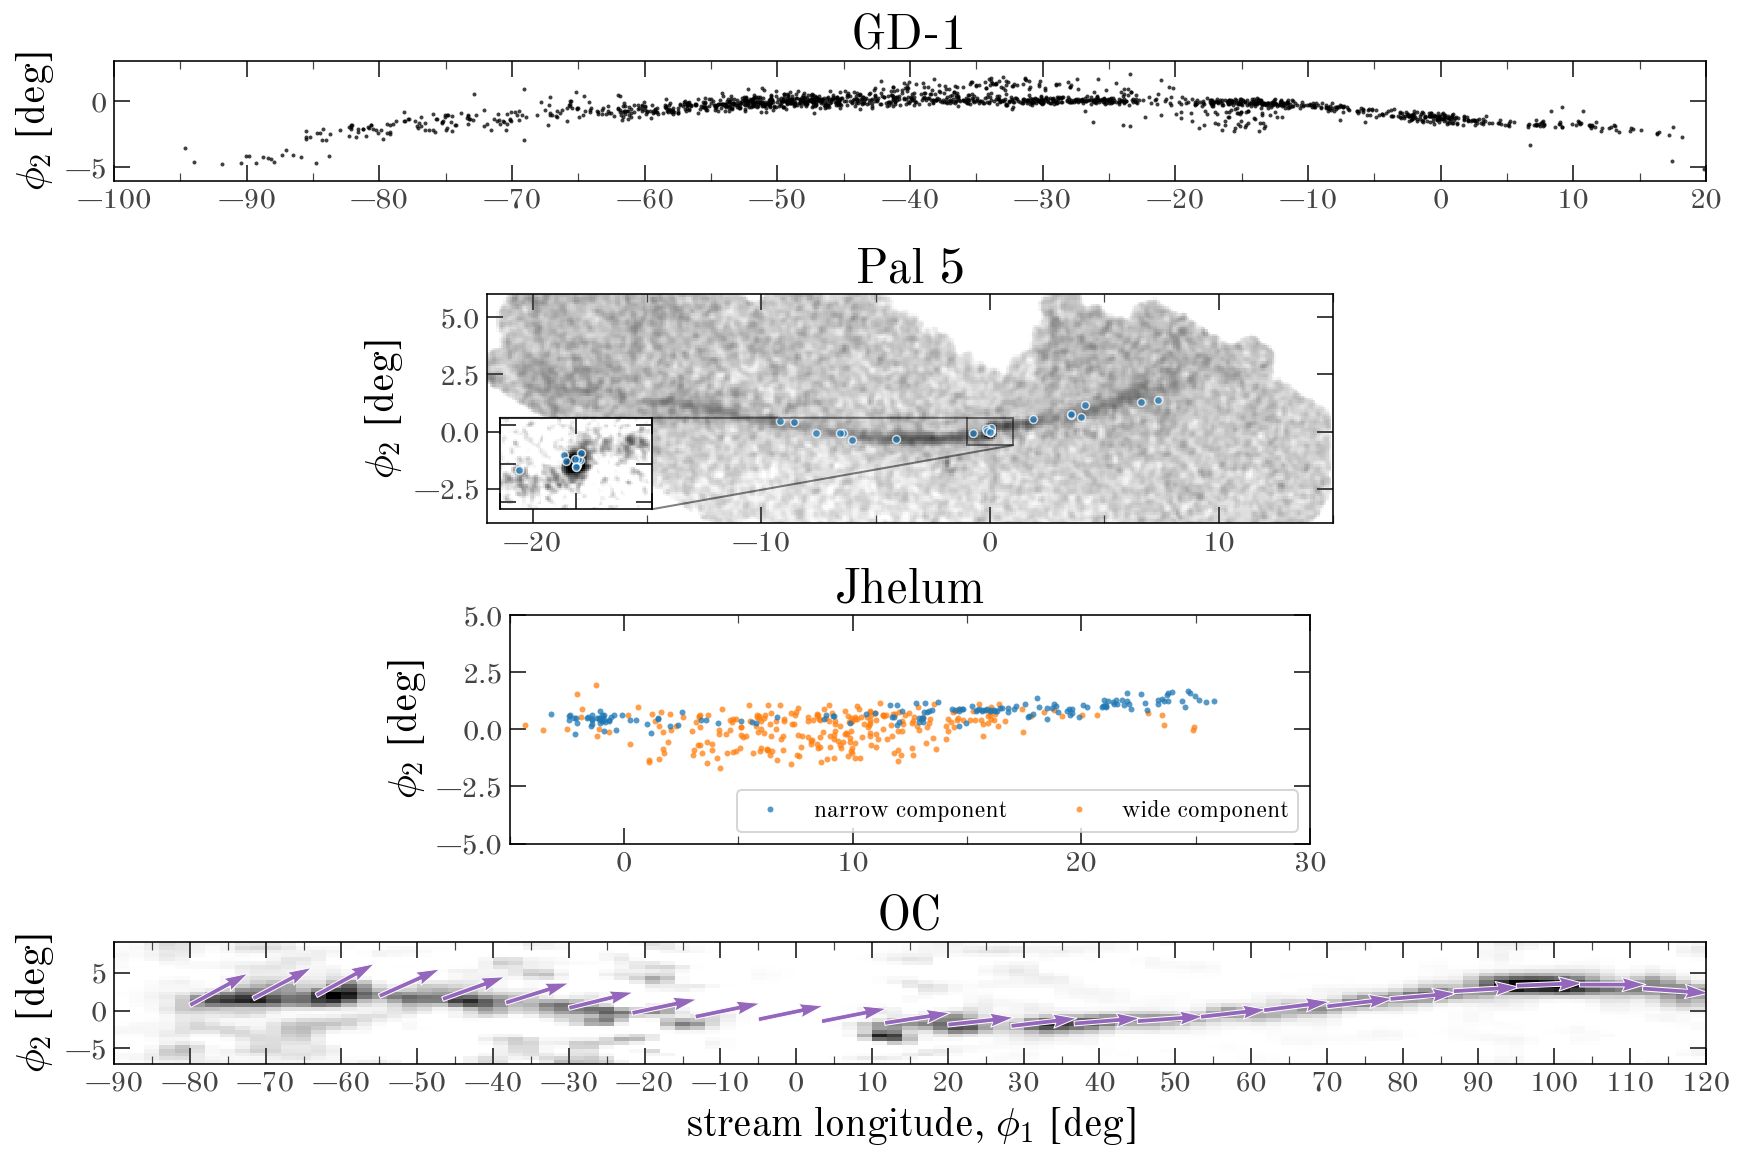

In [499]:
lims = [
    dict(xlim=(-100, 20), ylim=(-6, 3)),
    dict(xlim=(-22, 15), ylim=(-4, 6)),
    dict(xlim=(-5, 30), ylim=(-5, 5)),
    dict(xlim=(-90, 120), ylim=(-7, 9))
]
heights = np.array([l["ylim"][1] - l["ylim"][0] for l in lims])
heights = heights / heights.max()

fig, axes = plt.subplots(
    4,
    1,
    figsize=(3 * 4, 8),
    # layout="constrained",
    # gridspec_kw={"height_ratios": heights},
)

# GD-1
ptstyle = {"marker": "o", "ls": "none", "mew": 0.0, "alpha": 0.75, "ms": 2.0}
ax = axes[0]
ax.plot(stream_c["gd-1"].phi1.degree, stream_c["gd-1"].phi2.degree, **ptstyle)
ax.set(title="GD-1")

# Pal 5
ax = axes[1]
norm = mpl.colors.LogNorm(vmin=1.0, vmax=2e1)
ax.pcolormesh(
    pal5_im["xe"],
    pal5_im["ye"],
    pal5_im["H"].T,
    cmap="Greys",
    norm=norm,
)

ax_inset = ax.inset_axes(
    [0.015, 0.06, 0.18, 0.4],
    xlim=(-1.0, 1.0),
    ylim=(-0.6, 0.6),
    xticklabels=[],
    yticklabels=[],
)
ax_inset.set_aspect("equal")
# ax_inset.plot(stream_c["pal5"].phi1.degree, stream_c["pal5"].phi2.degree, **ptstyle)
ax_inset.pcolormesh(
    pal5_inset["xe"],
    pal5_inset["ye"],
    pal5_inset["H"].T,
    cmap="Greys",
    norm=mpl.colors.LogNorm(vmin=0.2, vmax=4),
)
ax.indicate_inset_zoom(ax_inset, edgecolor="k")

ptstyle = {
    "marker": "o",
    "ls": "none",
    "mew": 0.75,
    "mec": "w",
    "alpha": 0.75,
    "ms": 4.0,
    "color": "tab:blue",
}
for _ax in [ax, ax_inset]:
    _ax.plot(pal5_rrl_c.phi1.degree, pal5_rrl_c.phi2.degree, **ptstyle)

ax.set(title="Pal 5")

# Jhelum
ax = axes[2]

ptstyle = {"marker": "o", "ls": "none", "mew": 0.0, "alpha": 0.75, "ms": 3.0}
for c, color, name, zorder in zip(
    stream_c["jhelum"],
    ["tab:blue", "tab:orange"],
    ["narrow component", "wide component"],
    [10, 5]
):
    ax.plot(c.phi1.degree, c.phi2.degree, label=name, color=color, zorder=zorder, **ptstyle)

ax.legend(loc="lower right", fontsize=12, ncols=2)
ax.set(title="Jhelum")

# Orphan-Chenab
ax = axes[3]
ax.imshow(
    convolve(orp_im.T, Gaussian2DKernel(1.0)),
    extent=(-90, 120, -7, 9),
    cmap="Greys",
    vmin=0,
    vmax=4,
    origin="lower",
)

ax.quiver(
    orp_track_c_refl.phi1.degree,
    orp_track_c_refl.phi2.degree,
    pm[:, 0],
    pm[:, 1],
    scale=12,
    width=3e-3,
    color="tab:purple",
    linewidth=0.5,
    edgecolor="w",
)
ax.set(
    title="OC",
    xlabel="stream longitude, $\phi_1$ [deg]",
)

for ax, lim in zip(axes, lims):
    ax.set(
        aspect=1.0,
        **lim,
        ylabel="$\phi_2$ [deg]"
    )

axes[0].set_xticks(np.arange(-100, 20+1, 10))
axes[0].set_xticks(np.arange(-100, 20+1, 5), minor=True)

axes[1].set_xticks(np.arange(-20, 15+1, 10))
axes[1].set_xticks(np.arange(-20, 15+1, 5), minor=True)

axes[2].set_xticks(np.arange(0, 30+1, 10))
axes[2].set_xticks(np.arange(-5, 30+1, 5), minor=True)

axes[3].set_xticks(np.arange(-90, 120+1, 10))
axes[3].set_xticks(np.arange(-90, 120+1, 5), minor=True);

# fig.subplots_adjust(hspace=0.1)

fig.savefig("../tex/figures/stream-density-structure.pdf", dpi=250)